In [1]:
import pandas as pd
import numpy as np
import gradio as gr
import seaborn as sn
import matplotlib.pyplot as mp
import warnings
import plotly.express as px
warnings.filterwarnings('ignore')

In [2]:
from sklearn.compose import ColumnTransformer as CT
from sklearn.pipeline import Pipeline as PP
from sklearn.model_selection import GridSearchCV as GSCV, train_test_split as TTS
from sklearn.preprocessing import OrdinalEncoder as OE,OneHotEncoder as OHE,StandardScaler as SS,PowerTransformer as PT
from sklearn.metrics import auc,roc_curve as rc,ConfusionMatrixDisplay as CMD,confusion_matrix as CM,classification_report as CR,accuracy_score as AS

In [3]:
from sklearn.ensemble import AdaBoostClassifier as ABC,RandomForestClassifier as RFC,GradientBoostingClassifier as GBC
from sklearn.svm import SVC 
from xgboost import XGBClassifier as XGBC
from sklearn.linear_model import LogisticRegression as LO
from sklearn.naive_bayes import GaussianNB as GNB,MultinomialNB as MNB,BernoulliNB as BNB
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.neighbors import KNeighborsClassifier as KNN

In [4]:
t=pd.read_csv("heart_attack_analysis.csv")
t.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [5]:
t.shape

(303, 14)

In [6]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [7]:
t.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

In [8]:
t.duplicated().sum()

np.int64(1)

In [9]:
t.drop_duplicates(inplace=True)

# Age

## Increased Risk with Age:
The risk of developing heart disease increases substantially as people age. This is due to natural changes in the cardiovascular system, such as stiffening arteries and thickened heart walls.   
According to sources like the American Heart Association, the average age of a first heart attack is around 65.5 for men and 72 for women.   
## Younger Adults at Risk:
While heart disease is more common in older adults, it can and does occur in younger people.   
There's a noticeable trend of increasing heart attack rates in individuals under 40.
Factors like unhealthy lifestyle choices, genetic predispositions, and certain medical conditions contribute to this trend

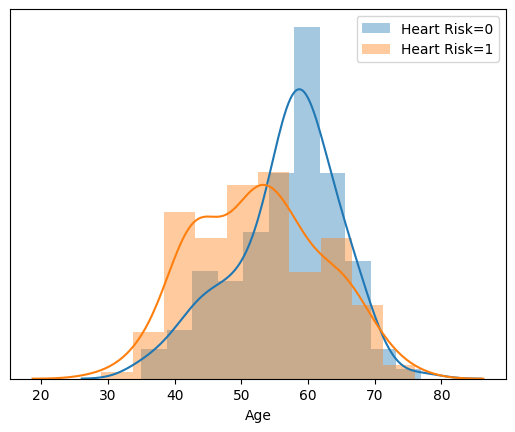

In [10]:
sn.distplot(t[t.target==0]["age"],label=["Heart Risk=0"])
sn.distplot(t[t.target==1]["age"],label=["Heart Risk=1"])
mp.ylabel("")
mp.xlabel("Age")
mp.yticks([])
mp.legend();

# Sex

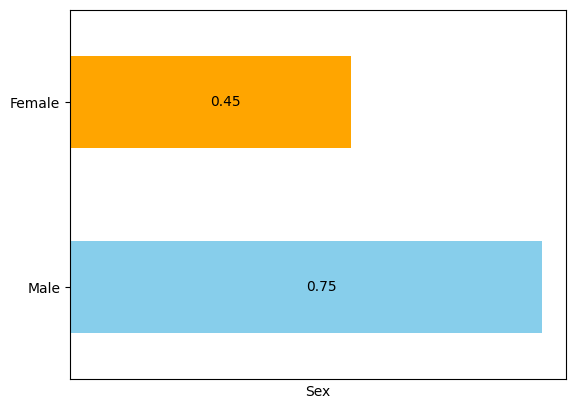

In [11]:
bars =t.groupby("sex")["target"].mean().plot(kind="barh",color=["skyblue","orange"])
for bar in bars.patches:
    mp.text(bar.get_width()/2,  
             bar.get_y() + bar.get_height() / 2,  
             f'{bar.get_width():.2f}', 
             va='center',  
             ha='left')
mp.xticks([])
mp.xlabel("Sex")
mp.ylabel("")
mp.yticks([0,1],['Male','Female']);

# Chest Pain

## 0: Typical angina:
#### This type of chest pain is usually triggered by physical exertion and relieved by rest. It's a classic symptom of reduced blood flow to the heart.
## 1: Atypical angina:
#### This type of chest pain can be less predictable and may not be directly related to physical activity. It can be harder to distinguish from other types of chest pain.
## 2: Non-anginal pain:
#### This refers to chest pain that is not caused by reduced blood flow to the heart. It might be related to other conditions, such as muscle pain or digestive issues.
## 3: Asymptomatic:
#### This means the patient experiences no chest pain at all. However, they may still have underlying heart disease.

In [12]:
t.cp.unique()

array([3, 2, 1, 0])

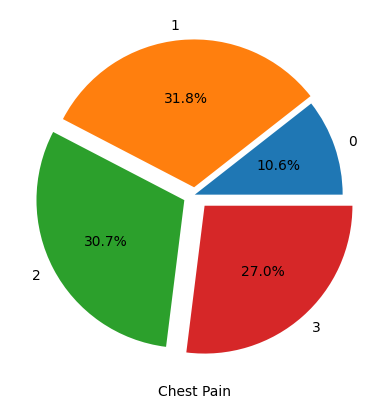

In [13]:
t.groupby("cp")["target"].mean().plot(kind="pie",autopct='%1.1f%%',explode=[0,0.05,0.08,0.1]);
mp.ylabel("")
mp.xlabel("Chest Pain");

## Cholesterol
##### Total Cholesterol:
This is the overall amount of cholesterol in your blood.   
Generally, less than 200 mg/dL is considered desirable.

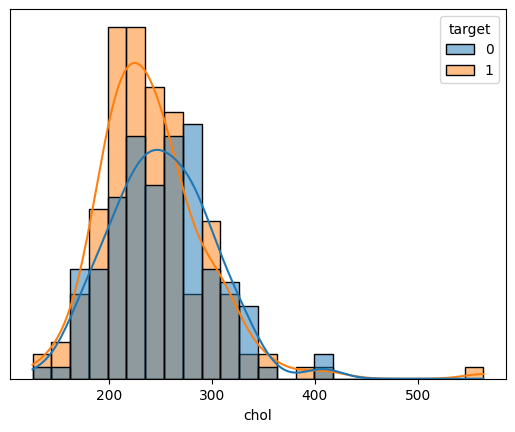

In [14]:
sn.histplot(data=t,x="chol",hue="target",kde=True)
mp.yticks([])
mp.ylabel("");

##### Understanding Thalach
Generally, a higher thalach value is often seen as a sign of better cardiovascular fitness.
However, when interpreting thalach in a heart disease dataset, it is used in conjunction with other factors

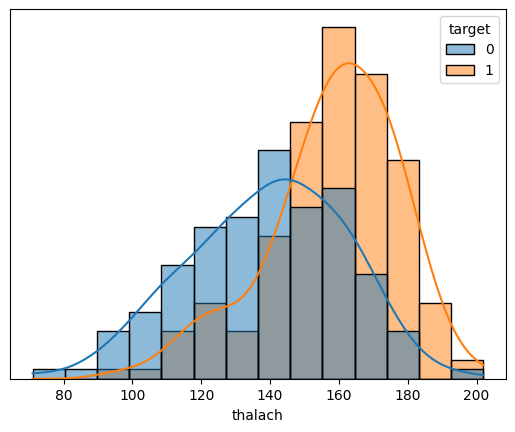

In [15]:
sn.histplot(data=t,x="thalach",hue="target",kde=True)
mp.yticks([])
mp.ylabel("");

In [16]:
x=t.drop("target",axis=1)
x

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [17]:
y=t.loc[:,"target"]
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: target, Length: 302, dtype: int64

In [18]:
xta,xte,yta,yte=TTS(x,y,random_state=10,test_size=0.3)

## Standard scaler

In [19]:
ct=CT([
    ("SS",SS(),[0,3,4,7,9])
],remainder="passthrough")

## Random Forest

In [20]:
pp_RFC=PP([
    ("Random_Forest",RFC())
],verbose=True)
p={"Random_Forest__criterion":["gini","entropy"],"Random_Forest__max_depth":range(10,16),"Random_Forest__min_samples_split":range(2,4),"Random_Forest__min_samples_leaf":range(1,2),"Random_Forest__max_features":["sqrt","log2"],"Random_Forest__bootstrap":[True,False]}
gscv_RFC=GSCV(pp_RFC,param_grid=p,cv=5,n_jobs=-1,scoring="roc_auc")
gscv_RFC.fit(xta,yta)

[Pipeline] ..... (step 1 of 1) Processing Random_Forest, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Random_Forest',
                                        RandomForestClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'Random_Forest__bootstrap': [True, False],
                         'Random_Forest__criterion': ['gini', 'entropy'],
                         'Random_Forest__max_depth': range(10, 16),
                         'Random_Forest__max_features': ['sqrt', 'log2'],
                         'Random_Forest__min_samples_leaf': range(1, 2),
                         'Random_Forest__min_samples_split': range(2, 4)},
             scoring='roc_auc')

## KNN

In [21]:
pp_KNN=PP([
    ("ct",ct),
    ("KNN",KNN())
],verbose=True)
p={'KNN__n_neighbors':range(4,10),"KNN__weights":["uniform","distance"],"KNN__algorithm":["auto","ball_tree","kd_tree","brute"],"KNN__p":[1,2,3]}
gscv_KNN=GSCV(pp_KNN,param_grid={},cv=5,n_jobs=-1,scoring="roc_auc")
gscv_KNN.fit(xta,yta)

[Pipeline] ................ (step 1 of 2) Processing ct, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing KNN, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('SS',
                                                                         StandardScaler(),
                                                                         [0, 3,
                                                                          4, 7,
                                                                          9])])),
                                       ('KNN', KNeighborsClassifier())],
                                verbose=True),
             n_jobs=-1, param_grid={}, scoring='roc_auc')

In [22]:
pp_ABC=PP([
    ("ABC",ABC())
],verbose=True)
gscv_ABC=GSCV(pp_ABC,param_grid={},cv=5,n_jobs=-1,scoring="roc_auc")
gscv_ABC.fit(xta,yta)

[Pipeline] ............... (step 1 of 1) Processing ABC, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ABC', AdaBoostClassifier())],
                                verbose=True),
             n_jobs=-1, param_grid={}, scoring='roc_auc')

In [23]:
pp_GBC=PP([
    ("GBC",GBC())
],verbose=True)
p={'GBC__loss':["log_loss","exponential"],"GBC__learning_rate":[0.1,0.5,0.9],"GBC__criterion":["friedman_mse","squared_error"],"GBC__min_samples_split":range(2,5),"GBC__min_samples_leaf":[1,2,3],"GBC__max_depth":[3,4,5,6],"GBC__max_features":["sqrt","log2"]}
gscv_GBC=GSCV(pp_GBC,param_grid=p,cv=5,n_jobs=-1,scoring="roc_auc")
gscv_GBC.fit(xta,yta)

[Pipeline] ............... (step 1 of 1) Processing GBC, total=   0.1s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('GBC', GradientBoostingClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'GBC__criterion': ['friedman_mse', 'squared_error'],
                         'GBC__learning_rate': [0.1, 0.5, 0.9],
                         'GBC__loss': ['log_loss', 'exponential'],
                         'GBC__max_depth': [3, 4, 5, 6],
                         'GBC__max_features': ['sqrt', 'log2'],
                         'GBC__min_samples_leaf': [1, 2, 3],
                         'GBC__min_samples_split': range(2, 5)},
             scoring='roc_auc')

In [24]:
pp_DT=PP([
    ("DT",DTC())
],verbose=True)
p={'DT__criterion':["gini","entropy"],"DT__splitter":["best","random"],"DT__max_depth":range(8,15),"DT__min_samples_split":[2,3,4],"DT__min_samples_leaf":[1,2,3,4],"DT__max_features":["sqrt","log2"],"DT__class_weight":["balanced"]}
gscv_DT=GSCV(pp_DT,param_grid=p,cv=5,n_jobs=-1,scoring="roc_auc")
gscv_DT.fit(xta,yta)

[Pipeline] ................ (step 1 of 1) Processing DT, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('DT', DecisionTreeClassifier())],
                                verbose=True),
             n_jobs=-1,
             param_grid={'DT__class_weight': ['balanced'],
                         'DT__criterion': ['gini', 'entropy'],
                         'DT__max_depth': range(8, 15),
                         'DT__max_features': ['sqrt', 'log2'],
                         'DT__min_samples_leaf': [1, 2, 3, 4],
                         'DT__min_samples_split': [2, 3, 4],
                         'DT__splitter': ['best', 'random']},
             scoring='roc_auc')

In [25]:
pp_GNB=PP([
    ("GNB",GNB())
],verbose=True)
gscv_GNB=GSCV(pp_GNB,param_grid={},cv=5,n_jobs=-1,scoring="roc_auc")
gscv_GNB.fit(xta,yta)

[Pipeline] ............... (step 1 of 1) Processing GNB, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('GNB', GaussianNB())], verbose=True),
             n_jobs=-1, param_grid={}, scoring='roc_auc')

In [26]:
pp_MNB=PP([
    ("MNB",MNB())
],verbose=True)
gscv_MNB=GSCV(pp_MNB,param_grid={},cv=5,n_jobs=-1,scoring="roc_auc")
gscv_MNB.fit(xta,yta)

[Pipeline] ............... (step 1 of 1) Processing MNB, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('MNB', MultinomialNB())], verbose=True),
             n_jobs=-1, param_grid={}, scoring='roc_auc')

In [27]:
pp_BNB=PP([
    ("BNB",BNB())
],verbose=True)
gscv_BNB=GSCV(pp_BNB,param_grid={},cv=5,n_jobs=-1,scoring="roc_auc")
gscv_BNB.fit(xta,yta)

[Pipeline] ............... (step 1 of 1) Processing BNB, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('BNB', BernoulliNB())], verbose=True),
             n_jobs=-1, param_grid={}, scoring='roc_auc')

In [28]:
pp_LO=PP([
    ("ct",ct),
    ("LO",LO())
],verbose=True)
gscv_LO=GSCV(pp_LO,param_grid={},cv=5,n_jobs=-1,scoring="roc_auc")
gscv_LO.fit(xta,yta)

[Pipeline] ................ (step 1 of 2) Processing ct, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing LO, total=   0.0s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('SS',
                                                                         StandardScaler(),
                                                                         [0, 3,
                                                                          4, 7,
                                                                          9])])),
                                       ('LO', LogisticRegression())],
                                verbose=True),
             n_jobs=-1, param_grid={}, scoring='roc_auc')

In [29]:
pp_XGBC=PP([
    ("XGBC",XGBC())
],verbose=True)
gscv_XGBC=GSCV(pp_XGBC,param_grid={},cv=5,n_jobs=-1,scoring="roc_auc")
gscv_XGBC.fit(xta,yta)

[Pipeline] .............. (step 1 of 1) Processing XGBC, total=   0.2s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('XGBC',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_bin=None,
                                                      max_cat_threshold=None,
                                                      max_cat_to_onehot=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...))],
                                verbose=True),
             n_jobs=-1, param_grid={}, scoring='roc_auc')

In [30]:
df=pd.DataFrame()
df['name']=["Ada_Boost","Gradient_Boost","Random_Forest","Decision_Tree","MNB","BNB","GNB","Logistic_Regression","KNN","XGBC"]
df['auc']=[AS(yte,gscv_ABC.predict(xte)),AS(yte,gscv_GBC.predict(xte)),AS(yte,gscv_RFC.predict(xte)),AS(yte,gscv_DT.predict(xte)),AS(yte,gscv_MNB.predict(xte)),AS(yte,gscv_BNB.predict(xte)),AS(yte,gscv_GNB.predict(xte)),AS(yte,gscv_LO.predict(xte)),AS(yte,gscv_KNN.predict(xte)),AS(yte,gscv_XGBC.predict(xte))]
df=df.sort_values(by='auc', ascending=False)

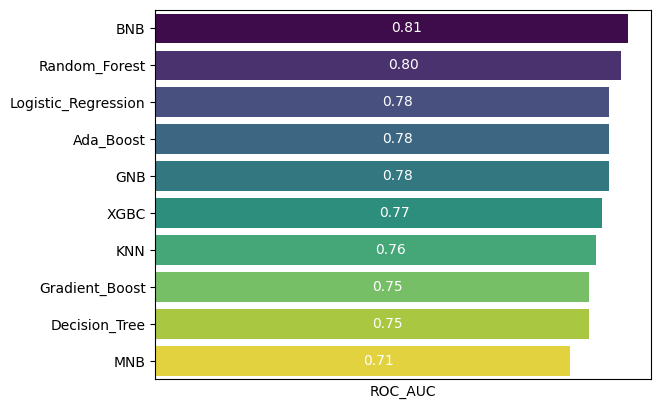

In [31]:
k=len(df)
colors = mp.cm.viridis(np.linspace(0, 1, k))
ax=sn.barplot(df,y="name",x="auc",orient="h",palette=colors)
for p in ax.patches:
    width = p.get_width() 
    mp.text(width/2,  
             p.get_y() + p.get_height() / 2, 
             '{:.2f}'.format(width),  
             ha='left',  
             va='center',color="white")
mp.xlabel('ROC_AUC')
mp.ylabel("")
mp.xticks([]);

In [32]:
def ROC_AUC(models,names,xta,yta): 
    fig, ax = mp.subplots(figsize=(8, 6))
    for model,name in zip(models,names):
        ypre=model.predict_proba(xta)
        fpr,tpr,thresh=rc(yta,ypre[:,-1])
        model_auc=auc(fpr,tpr)
        ind=np.argmax(tpr-fpr)
        threshold1=thresh[ind]
        x1=min(fpr)
        x2=max(tpr)
        y1=min(tpr)
        y2=max(fpr)
        ax.plot([x1,x2],[y1,y2],marker='o', linestyle='--',color="black")
        ax.plot(fpr,tpr,label=f"*{name}*:\nAUC ="+f"{model_auc:.4f}"+f" ||| Best Threshold ={threshold1:.4f}")
        ax.set_xlabel("False_Positive_Rate")
        ax.set_ylabel("True_Positive_Rate",labelpad=30,rotation=0)
        ax.legend()

In [58]:
def annot(fig,x,y,text,value):
                    fig.add_annotation(
                    x=x,
                    y=y,
                    text=f"<b>{text}</b>= <b>{value:.2f}</b>",
                    showarrow=True,
                    arrowhead=7,
                    ax=0,
                    ay=-40,
                    font=dict(size=10)
                    ) 

In [59]:
def tpr_fpr_display(fpr,tpr,thresh,fig):
                    max_tpr=max(tpr)
                    min_fpr=min(fpr)
                    max_tpr_ind=np.where(tpr==max(tpr))[0][0]
                    min_fpr_ind=np.where(fpr==min(fpr))[0][-1]
                    x_tpr=fpr[max_tpr_ind]
                    y_tpr=tpr[max_tpr_ind]
                    x_fpr=fpr[min_fpr_ind]
                    y_fpr=tpr[min_fpr_ind]   
                    

                    
                    annot(fig,x_tpr,y_tpr,'Max TPR Threshold',thresh[max_tpr_ind])
                    
                    annot(fig,x_fpr,y_fpr,'Min FPR Threshold',thresh[min_fpr_ind])
                    
                    return thresh[max_tpr_ind],thresh[min_fpr_ind]


In [60]:
def plot_all_in_one(models, names, xta, yta,min_fpr_bool=False,max_tpr_bool=False):
    if len(models)==1:
        fig = px.line(title=f"<b>ROC Curves for {names[0]} Model</b>",  
            labels={'False Positive Rate': 'FPR', 'True Positive Rate': 'TPR'})
        
    else:
        fig = px.line(title="<b>ROC Curves for Multiple Models</b>",  
            labels={'False Positive Rate': 'FPR', 'True Positive Rate': 'TPR'})

    for name, model in zip(names, models):
        try:
            ypre = model.predict_proba(xta)
            fpr, tpr, thresh = rc(yta, ypre[:, -1])
            roc_auc = auc(fpr, tpr)
            ind = np.argmax(tpr - fpr)
            threshold1 = thresh[ind]
            roc_df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr, 'Threshold': thresh})

            fig.add_scatter(x=roc_df['False Positive Rate'],  
                              y=roc_df['True Positive Rate'],  
                              mode='lines', 
                              name=f'{name} (AUC = {roc_auc:.4f}, Best Threshold = {threshold1:.2f})')
            annot(fig,fpr[ind],tpr[ind],"Threshold",threshold1)

            if max_tpr_bool==True and min_fpr_bool==True:
                max_tpr_ind,min_fpr_ind=tpr_fpr_display(fpr, tpr, thresh,fig)

        except AttributeError:
            print(f"Model {name} does not have predict_proba. Skipping.")
        except Exception as e:
            print(f"An error occurred with model {name}: {e}")

    fig.add_shape(
        type="line",
        x0=0, y0=0, x1=1, y1=1,
        line=dict(color="grey", width=2, dash="dash")
    )
    fig.update_layout(
        xaxis_title="False Positive Rate (FPR)",  
        yaxis_title="True Positive Rate (TPR)"  
    )

    fig.show(renderer='browser')
    if max_tpr_bool==True and min_fpr_bool==True:
        return max_tpr_ind,min_fpr_ind

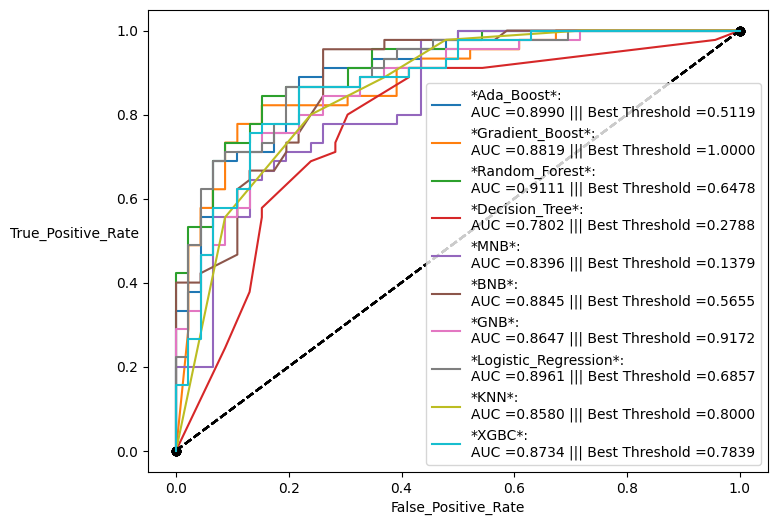

In [61]:
names=["Ada_Boost","Gradient_Boost","Random_Forest","Decision_Tree","MNB","BNB","GNB","Logistic_Regression","KNN","XGBC"]
models=[gscv_ABC,gscv_GBC,gscv_RFC,gscv_DT,gscv_MNB,gscv_BNB,gscv_GNB,gscv_LO,gscv_KNN,gscv_XGBC]
ROC_AUC(models,names,xte,yte)
plot_all_in_one(models,names,xte,yte)

In [71]:
names=["Ada_Boost"]
models=[gscv_ABC]

max_tpr_ind,min_fpr_ind=plot_all_in_one(models, names, xte, yte,True,True)

![Image Title](TPR_FPR.png)

In [72]:
def predict_heart_attack_risk(age, sex, cp, trestbps, chol, fbs, restecg, thalach,exang, oldpeak, slope, ca, thal):
    Sex=lambda sex:0 if sex=="Male" else 1
    sex=Sex(sex)
    input_list=[age, sex, cp, trestbps, chol, fbs, restecg, thalach,exang, oldpeak, slope, ca, thal]
    input_array=np.array(input_list).reshape(1,-1)
    probabilities = gscv_ABC.predict_proba(xta.iloc[0,:].values.reshape(1,-1))
    positive_class_probabilities = probabilities[:, 1]  # Probabilities of the positive class
    predictions = (positive_class_probabilities >= max_tpr_ind).astype(int)
    output=predictions[0]
    Output=lambda output:"Risk" if output==1 else "No Risk"
    return Output(output)


In [73]:
iface = gr.Interface(
    fn=predict_heart_attack_risk,
    inputs=[
        gr.Number(label="Age"),
        gr.Radio(["Male", "Female"],label="Sex"),
        gr.Radio([0,1,2,3],label="Chest Pain"),
        gr.Number(label="Trestbps"),
        gr.Number(label="Cholesterol"),
        gr.Radio([0,1],label="Fasting Blood Sugar (FBS)"),
        gr.Radio([0,1,2],label="Restecg"),
        gr.Number(label="Thalach"),
        gr.Radio([0,1],label="Exang"),
        gr.Number(label="Oldpeak"),
        gr.Radio([0,1,2],label="Slope"),
        gr.Radio([0,1,2,3,4],label="Ca"),
        gr.Radio([0,1,2,3],label="Thal"),
    ],
    outputs=gr.Textbox(label="Heart Attack Risk"),
    title="Heart Attack Risk Prediction",
    description="This tool estimates heart attack risk based on age and blood pressure. It provides a preliminary assessment and should not replace professional medical advice.")

In [74]:
iface.close()
iface.launch()

* Running on local URL:  http://127.0.0.1:7863

To create a public link, set `share=True` in `launch()`.


In [79]:
t.sample(2)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
283,40,1,0,152,223,0,1,181,0,0.0,2,0,3,0
208,49,1,2,120,188,0,1,139,0,2.0,1,3,3,0


Created dataset file at: .gradio\flagged\dataset1.csv
